In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, coint, grangercausalitytests
import statsmodels.api as sm

In [2]:
# set theme
plt.style.use('seaborn')
sns.set_style('darkgrid')

In [3]:
stocks = ['TRN', 'BDN', 'CMC', 'NYT', 'LEG', 'VNO', 'HLX', 'ORI', 'HP', 'EQC', 'MTOR', 
          'DKS', 'SEE', 'EAT', 'AGCO', 'AIV', 'WSM', 'BIG', 'HFC', 'AN', 'ENDP', 'OI', 
          'FFIV', 'AXL', 'VSH', 'NCR', 'MDRX', 'UIS', 'CRUS', 'FLR', 'MUR', 'ATI', 'PBI', 
          'PWR', 'TEX', 'RRC', 'FL', 'NVAX', 'LPX', 'CMA', 'AMKR', 'RMBS', 'MFA', 'ZION', 
          'HOG', 'UNM', 'IVZ', 'NWL', 'GME', 'JWN', 'NUAN', 'ANF', 'FHN', 'JBL', 'URBN', 
          'PBCT', 'HRB', 'LNC', 'RDN', 'TGNA', 'NYCB', 'WEN', 'CNX', 'STLD', 'TOL', 'BBBY', 
          'APA', 'MAT', 'BPOP', 'KBH', 'PTEN', 'SANM', 'DVN', 'MOS', 'OVV', 'TPR', 'CLF', 
          'AEO', 'KSS', 'SWN', 'MTG', 'GT', 'NOV', 'CDE', 'IPG', 'JBLU', 'THC', 'ODP', 
          'RIG', 'SNV', 'M', 'ON', 'GPS', 'X', 'MRO', 'XRX', 'JNPR', 'CAR', 'RAD', 'SLM']

In [4]:
start = '2010-01-01'
end = '2012-12-31'

In [5]:
'''
trn = yf.download('TRN', start, end)
prices = pd.DataFrame(index=trn.index, columns=stocks)
prices['TRN'] = trn['Adj Close']
for s in stocks[1:]:
    pdf = yf.download(s, start, end)
    prices[s] = pdf['Adj Close']
'''

"\ntrn = yf.download('TRN', start, end)\nprices = pd.DataFrame(index=trn.index, columns=stocks)\nprices['TRN'] = trn['Adj Close']\nfor s in stocks[1:]:\n    pdf = yf.download(s, start, end)\n    prices[s] = pdf['Adj Close']\n"

In [6]:
#prices.to_csv('vbr100_10_13.csv')

In [7]:
prices = pd.read_csv('vbr100_10_13.csv', index_col=0)

In [8]:
log_prices = np.log(prices)
returns = prices.pct_change().dropna()
log_returns = log_prices.diff().dropna()

In [9]:
form_start = '2010-01-01'
form_end = '2011-12-31'
trade_start = '2012-01-01'
trade_end = '2012-12-31'

log_prices_form = log_prices.loc[form_start:form_end]
log_prices_trade = log_prices.loc[trade_start:trade_end]
log_returns_form = log_returns.loc[form_start:form_end]
log_returns_trade = log_returns.loc[trade_start:trade_end]
returns_form = returns.loc[form_start:form_end]
returns_trade = returns.loc[trade_start:trade_end]

In [10]:
selected_pairs = []
selected_stocks = []

for s1 in stocks:
    for s2 in stocks:
        if (s1!=s2) and (s1 not in selected_stocks) and (s2 not in selected_stocks):
            if (coint(log_prices_form[s1], log_prices_form[s2])[1] < 0.01):
                selected_stocks.append(s1)
                selected_stocks.append(s2)
                selected_pairs.append(f'{s1}-{s2}')

In [11]:
selected_pairs

['BDN-ZION',
 'CMC-LPX',
 'NYT-SNV',
 'LEG-TRN',
 'HLX-JWN',
 'ORI-BPOP',
 'EQC-NVAX',
 'SEE-JNPR',
 'EAT-WEN',
 'OI-CMA',
 'AXL-IVZ',
 'NCR-HFC',
 'MDRX-KSS',
 'ATI-DVN',
 'FL-MAT',
 'AMKR-NYCB',
 'UNM-ON',
 'FHN-KBH',
 'CNX-THC',
 'JBLU-MTG',
 'SLM-HP']

In [12]:
len(selected_pairs)

21

In [13]:
def parse_pair(pair):
    s1 = pair[:pair.find('-')]
    s2 = pair[pair.find('-')+1:]
    return s1,s2

In [14]:
import random

def shuffle_positions(positions_df):
    
    positions = positions_df.copy().values
    
    # shuffle positions within each column
    for col in range(positions.shape[1]):
        split =  np.split(positions[:,col], np.where((np.diff(positions[:,col]) != 0))[0]+1)
        pos = [x for x in split if x[0]!=0] # all non-zero positions
        pos_length = sum([len(x) for x in pos]) # total length in days
        zero_length = len(positions[:,col]) - pos_length
        pos += np.split(np.array([0]*zero_length), np.arange(1,zero_length))
        random.shuffle(pos)
        pos = np.concatenate(pos).astype(int)
        positions[:,col] = pos
    # shuffle columns
    np.random.shuffle(np.transpose(positions))
    
    shuffled_df = pd.DataFrame(positions, index=positions_df.index, columns=positions_df.columns)
    
    return shuffled_df

In [15]:
def calculate_metrics(cumret):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD, maxDDD

# Baseline algo

In [16]:
r = 0.75 # standard deviation threshold

positions_short = pd.DataFrame(index=returns_trade.index, columns=selected_stocks)
positions_long = pd.DataFrame(index=returns_trade.index, columns=selected_stocks)

for pair in selected_pairs:
    s1,s2 = parse_pair(pair)
    # calculate parameters using historical data
    model = sm.OLS(log_prices_form[s1], sm.add_constant(log_prices_form[s2]))
    res = model.fit()
    mu = res.resid.mean() # spread historical mean
    sigma = res.resid.std() # spread historical sd
    # calculate spread
    spread = log_prices_trade[s1] - res.predict(sm.add_constant(log_prices_trade[s2]))
    # calculate positions
    positions_short.loc[spread > mu+r*sigma, [s1,s2]] = [-1,1]
    positions_short.loc[spread < mu, [s1,s2]] = [0,0]
    positions_long.loc[spread < mu-r*sigma, [s1,s2]] = [1,-1]
    positions_long.loc[spread > mu, [s1,s2]] = [0,0]

positions_short.fillna(method='ffill', inplace=True)
positions_short.fillna(0, inplace=True)
positions_long.fillna(method='ffill', inplace=True)
positions_long.fillna(0, inplace=True)
positions = positions_long + positions_short

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [17]:
# calculate returns
ret = (positions.shift() * returns_trade[selected_stocks]).sum(axis=1)/len(selected_pairs)
cumret = np.nancumprod(ret + 1)

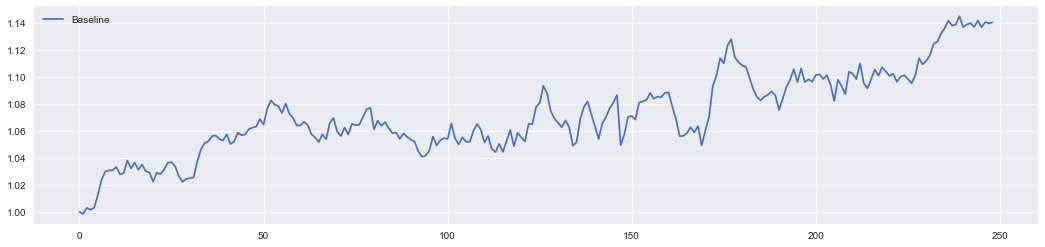

In [18]:
plt.figure(figsize=(18,4))
plt.plot(cumret, label='Baseline')
plt.legend()

In [19]:
bootstrap_trs = [] # total returns

for N in range(5000):
    positions_bootstrap = shuffle_positions(positions)
    cumret_bootstrap = np.nancumprod((positions_bootstrap.shift().dropna() * returns_trade[selected_stocks]).sum(axis=1) 
                                / len(selected_pairs) + 1)
    bootstrap_trs.append(calculate_metrics(cumret_bootstrap)[0]) # save total return
    
bootstrap_trs = np.array(bootstrap_trs)

In [20]:
results_df = pd.DataFrame(columns=['Total return', 'APR', 'Sharpe', 
                                   'maxDD', 'maxDDD', '% random portfolios beaten'])
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret)
pct_beaten = 100 * (1 - len(bootstrap_trs[bootstrap_trs>total_return]) / len(bootstrap_trs))
results_df.loc['Baseline'] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten

In [21]:
# remove positions that are not closed by the end of trading period
for s in positions.columns:
    for t in positions.index[::-1]:
        if positions.loc[t,s]==0:
            break
        else:
            positions.loc[t,s]=0

In [22]:
ret = (positions.shift() * returns_trade[selected_stocks]).sum(axis=1)/len(selected_pairs)
cumret = np.nancumprod(ret + 1)

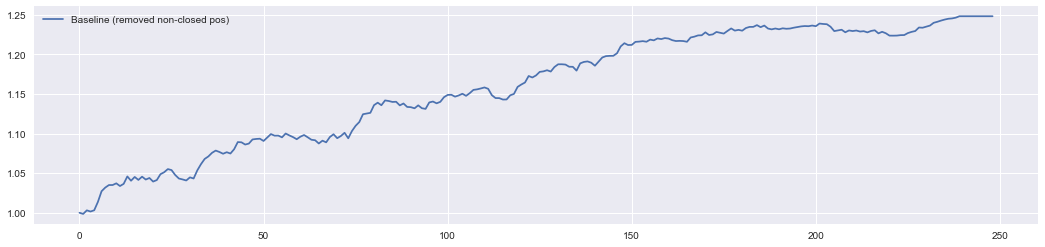

In [23]:
plt.figure(figsize=(18,4))
plt.plot(cumret, label='Baseline (removed non-closed pos)')
plt.legend()

In [24]:
calculate_metrics(cumret)[0]

0.24800778045152794

In [25]:
bootstrap_trs = [] # total returns

for N in range(5000):
    positions_bootstrap = shuffle_positions(positions)
    cumret_bootstrap = np.nancumprod((positions_bootstrap.shift().dropna() * returns_trade[selected_stocks]).sum(axis=1) 
                                / len(selected_pairs) + 1)
    bootstrap_trs.append(calculate_metrics(cumret_bootstrap)[0]) # save total return
    
bootstrap_trs = np.array(bootstrap_trs)

In [26]:
len(bootstrap_trs[bootstrap_trs>calculate_metrics(cumret)[0]]) / len(bootstrap_trs)

0.0002

In [27]:
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret)
pct_beaten = 100 * (1 - len(bootstrap_trs[bootstrap_trs>total_return]) / len(bootstrap_trs))
results_df.loc['Baseline (removed non-closed pos)'] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten

In [28]:
results_df

,Total return,APR,Sharpe,maxDD,maxDDD,% random portfolios beaten
Baseline,0.140320,0.142126,1.327768,-0.046513,73.0,93.48
Baseline (removed non-closed pos),0.248008,0.251343,4.622586,-0.013644,30.0,99.98


# Using only pairs with Granger-causality relationship

In [29]:
from statsmodels.tsa.stattools import adfuller, coint, grangercausalitytests
s1,s2 = parse_pair(selected_pairs[0])
gct = grangercausalitytests(log_prices_form[[s1, s2]], maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8153  , p=0.3670  , df_denom=500, df_num=1
ssr based chi2 test:   chi2=0.8202  , p=0.3651  , df=1
likelihood ratio test: chi2=0.8195  , p=0.3653  , df=1
parameter F test:         F=0.8153  , p=0.3670  , df_denom=500, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6577  , p=0.5185  , df_denom=497, df_num=2
ssr based chi2 test:   chi2=1.3286  , p=0.5146  , df=2
likelihood ratio test: chi2=1.3268  , p=0.5151  , df=2
parameter F test:         F=0.6577  , p=0.5185  , df_denom=497, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7626  , p=0.5154  , df_denom=494, df_num=3
ssr based chi2 test:   chi2=2.3202  , p=0.5087  , df=3
likelihood ratio test: chi2=2.3148  , p=0.5097  , df=3
parameter F test:         F=0.7626  , p=0.5154  , df_denom=494, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6912  , p=0.5983  

In [30]:
maxlag=5

selected_pairs_gc = []
selected_stocks_gc = []

for pair in selected_pairs:
    s1,s2 = parse_pair(pair)
    
    gct12 = grangercausalitytests(log_prices_form[[s1,s2]], maxlag=maxlag)
    pvals12 = [gct12[x][0]['ssr_ftest'][1] for x in range(1,maxlag+1)]
    pvals12 = np.array(pvals12)
    if len(pvals12[pvals12<0.01])>0:
        selected_pairs_gc.append(f'{s1}-{s2}')
        selected_stocks_gc.append(s1)
        selected_stocks_gc.append(s2)
    else: # switch Granger-leader and Granger-follower
        gct21 = grangercausalitytests(log_prices_form[[s2,s1]], maxlag=maxlag)
        pvals21 = [gct21[x][0]['ssr_ftest'][1] for x in range(1,maxlag+1)]
        pvals21 = np.array(pvals21)
        if len(pvals21[pvals21<0.01])>0:
            selected_pairs_gc.append(f'{s2}-{s1}')
            selected_stocks_gc.append(s2)
            selected_stocks_gc.append(s1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8153  , p=0.3670  , df_denom=500, df_num=1
ssr based chi2 test:   chi2=0.8202  , p=0.3651  , df=1
likelihood ratio test: chi2=0.8195  , p=0.3653  , df=1
parameter F test:         F=0.8153  , p=0.3670  , df_denom=500, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6577  , p=0.5185  , df_denom=497, df_num=2
ssr based chi2 test:   chi2=1.3286  , p=0.5146  , df=2
likelihood ratio test: chi2=1.3268  , p=0.5151  , df=2
parameter F test:         F=0.6577  , p=0.5185  , df_denom=497, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7626  , p=0.5154  , df_denom=494, df_num=3
ssr based chi2 test:   chi2=2.3202  , p=0.5087  , df=3
likelihood ratio test: chi2=2.3148  , p=0.5097  , df=3
parameter F test:         F=0.7626  , p=0.5154  , df_denom=494, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6912  , p=0.5983  

In [31]:
selected_pairs_gc

['HLX-JWN',
 'BPOP-ORI',
 'SEE-JNPR',
 'WEN-EAT',
 'CMA-OI',
 'NCR-HFC',
 'KSS-MDRX',
 'MAT-FL',
 'FHN-KBH',
 'JBLU-MTG']

In [32]:
len(selected_pairs_gc)

10

In [33]:
r = 0.75 # standard deviation threshold

positions_short = pd.DataFrame(index=returns_trade.index, columns=selected_stocks_gc)
positions_long = pd.DataFrame(index=returns_trade.index, columns=selected_stocks_gc)

for pair in selected_pairs_gc:
    s1,s2 = parse_pair(pair)
    # calculate parameters using historical data
    model = sm.OLS(log_prices_form[s1], sm.add_constant(log_prices_form[s2]))
    res = model.fit()
    mu = res.resid.mean() # spread historical mean
    sigma = res.resid.std() # spread historical sd
    # calculate spread
    spread = log_prices_trade[s1] - res.predict(sm.add_constant(log_prices_trade[s2]))
    # calculate positions
    positions_short.loc[spread > mu+r*sigma, [s1,s2]] = [-1,1]
    positions_short.loc[spread < mu, [s1,s2]] = [0,0]
    positions_long.loc[spread < mu-r*sigma, [s1,s2]] = [1,-1]
    positions_long.loc[spread > mu, [s1,s2]] = [0,0]

positions_short.fillna(method='ffill', inplace=True)
positions_short.fillna(0, inplace=True)
positions_long.fillna(method='ffill', inplace=True)
positions_long.fillna(0, inplace=True)
positions = positions_long + positions_short

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [34]:
ret = (positions.shift() * returns_trade[selected_stocks_gc]).sum(axis=1)/len(selected_pairs_gc)
cumret = np.nancumprod(ret + 1)

In [35]:
calculate_metrics(cumret)[0]

0.2839011387524566

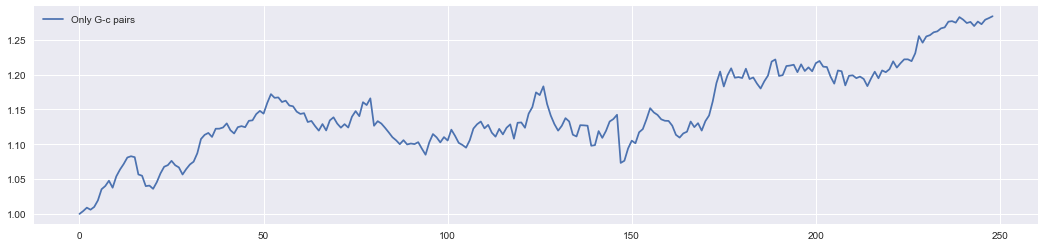

In [36]:
plt.figure(figsize=(18,4))
plt.plot(cumret, label='Only G-c pairs')
plt.legend()

In [37]:
bootstrap_trs = [] # total returns

for N in range(5000):
    positions_bootstrap = shuffle_positions(positions)
    cumret_bootstrap = np.nancumprod((positions_bootstrap.shift().dropna() * returns_trade[selected_stocks_gc]).sum(axis=1) 
                                / len(selected_pairs_gc) + 1)
    bootstrap_trs.append(calculate_metrics(cumret_bootstrap)[0]) # save total return
    
bootstrap_trs = np.array(bootstrap_trs)

In [38]:
len(bootstrap_trs[bootstrap_trs>calculate_metrics(cumret)[0]]) / len(bootstrap_trs)

0.0204

In [39]:
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret)
pct_beaten = 100 * (1 - len(bootstrap_trs[bootstrap_trs>total_return]) / len(bootstrap_trs))
results_df.loc['Only G-c pairs'] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten

In [40]:
# remove positions that are not closed by the end of trading period
for s in positions.columns:
    for t in positions.index[::-1]:
        if positions.loc[t,s]==0:
            break
        else:
            positions.loc[t,s]=0

In [41]:
ret = (positions.shift() * returns_trade[selected_stocks_gc]).sum(axis=1)/len(selected_pairs_gc)
cumret = np.nancumprod(ret + 1)

In [42]:
calculate_metrics(cumret)[0]

0.3354442064083496

In [43]:
bootstrap_trs = [] # total returns

for N in range(5000):
    positions_bootstrap = shuffle_positions(positions)
    cumret_bootstrap = np.nancumprod((positions_bootstrap.shift().dropna() * returns_trade[selected_stocks_gc]).sum(axis=1) 
                                / len(selected_pairs_gc) + 1)
    bootstrap_trs.append(calculate_metrics(cumret_bootstrap)[0]) # save total return
    
bootstrap_trs = np.array(bootstrap_trs)

In [44]:
len(bootstrap_trs[bootstrap_trs>calculate_metrics(cumret)[0]]) / len(bootstrap_trs)

0.001

In [45]:
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret)
pct_beaten = 100 * (1 - len(bootstrap_trs[bootstrap_trs>total_return]) / len(bootstrap_trs))
results_df.loc['Only G-c pairs (removed non-closed pos)'] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten

In [46]:
results_df

,Total return,APR,Sharpe,maxDD,maxDDD,% random portfolios beaten
Baseline,0.140320,0.142126,1.327768,-0.046513,73.0,93.48
Baseline (removed non-closed pos),0.248008,0.251343,4.622586,-0.013644,30.0,99.98
Only G-c pairs,0.283901,0.287773,1.713871,-0.092917,71.0,97.96
Only G-c pairs (removed non-closed pos),0.335444,0.340106,3.435511,-0.043213,50.0,99.90


# Trading only in Granger-followers

In [61]:
r = 0.75 # standard deviation threshold

positions_short = pd.DataFrame(index=returns_trade.index, columns=selected_stocks_gc)
positions_long = pd.DataFrame(index=returns_trade.index, columns=selected_stocks_gc)

for pair in selected_pairs_gc:
    s1,s2 = parse_pair(pair)
    # calculate parameters using historical data
    model = sm.OLS(log_prices_form[s1], sm.add_constant(log_prices_form[s2]))
    res = model.fit()
    mu = res.resid.mean() # spread historical mean
    sigma = res.resid.std() # spread historical sd
    # calculate spread
    spread = log_prices_trade[s1] - res.predict(sm.add_constant(log_prices_trade[s2]))
    # calculate positions
    positions_short.loc[spread > mu+r*sigma, [s1,s2]] = [-1,0]
    positions_short.loc[spread < mu, [s1,s2]] = [0,0]
    positions_long.loc[spread < mu-r*sigma, [s1,s2]] = [1,0]
    positions_long.loc[spread > mu, [s1,s2]] = [0,0]

positions_short.fillna(method='ffill', inplace=True)
positions_short.fillna(0, inplace=True)
positions_long.fillna(method='ffill', inplace=True)
positions_long.fillna(0, inplace=True)
positions = positions_long + positions_short

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [62]:
ret = (positions.shift() * returns_trade[selected_stocks_gc]).sum(axis=1)/len(selected_pairs_gc)
cumret = np.nancumprod(ret + 1)

In [63]:
calculate_metrics(cumret)[0]

0.3038964211357902

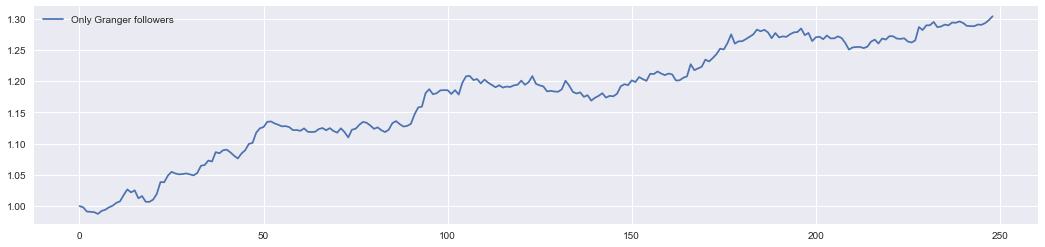

In [64]:
plt.figure(figsize=(18,4))
plt.plot(cumret, label='Only Granger followers')
plt.legend()

In [51]:
bootstrap_trs = [] # total returns

for N in range(5000):
    positions_bootstrap = shuffle_positions(positions)
    cumret_bootstrap = np.nancumprod((positions_bootstrap.shift().dropna() * returns_trade[selected_stocks_gc]).sum(axis=1) 
                                / len(selected_pairs_gc) + 1)
    bootstrap_trs.append(calculate_metrics(cumret_bootstrap)[0]) # save total return
    
bootstrap_trs = np.array(bootstrap_trs)

In [52]:
len(bootstrap_trs[bootstrap_trs>calculate_metrics(cumret)[0]]) / len(bootstrap_trs)

0.002

In [53]:
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret)
pct_beaten = 100 * (1 - len(bootstrap_trs[bootstrap_trs>total_return]) / len(bootstrap_trs))
results_df.loc['Only Granger-followers'] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten

In [54]:
# remove positions that are not closed by the end of trading period
for s in positions.columns:
    for t in positions.index[::-1]:
        if positions.loc[t,s]==0:
            break
        else:
            positions.loc[t,s]=0

In [55]:
ret = (positions.shift() * returns_trade[selected_stocks_gc]).sum(axis=1)/len(selected_pairs_gc)
cumret = np.nancumprod(ret + 1)

In [56]:
calculate_metrics(cumret)[0]

0.2941631805383145

In [57]:
bootstrap_trs = [] # total returns

for N in range(5000):
    positions_bootstrap = shuffle_positions(positions)
    cumret_bootstrap = np.nancumprod((positions_bootstrap.shift().dropna() * returns_trade[selected_stocks_gc]).sum(axis=1) 
                                / len(selected_pairs_gc) + 1)
    bootstrap_trs.append(calculate_metrics(cumret_bootstrap)[0]) # save total return
    
bootstrap_trs = np.array(bootstrap_trs)

In [58]:
len(bootstrap_trs[bootstrap_trs>calculate_metrics(cumret)[0]]) / len(bootstrap_trs)

0.0

In [59]:
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret)
pct_beaten = 100 * (1 - len(bootstrap_trs[bootstrap_trs>total_return]) / len(bootstrap_trs))
results_df.loc['Only Granger-followers (removed non-closed pos)'] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten

In [60]:
results_df

,Total return,APR,Sharpe,maxDD,maxDDD,% random portfolios beaten
Baseline,0.140320,0.142126,1.327768,-0.046513,73.0,93.48
Baseline (removed non-closed pos),0.248008,0.251343,4.622586,-0.013644,30.0,99.98
Only G-c pairs,0.283901,0.287773,1.713871,-0.092917,71.0,97.96
Only G-c pairs (removed non-closed pos),0.335444,0.340106,3.435511,-0.043213,50.0,99.90
Only Granger-followers,0.303896,0.308072,3.228988,-0.032727,48.0,99.80
Only Granger-followers (removed non-closed pos),0.294163,0.298190,4.050198,-0.023272,71.0,100.00


In [66]:
results_df.iloc[::2]

,Total return,APR,Sharpe,maxDD,maxDDD,% random portfolios beaten
Baseline,0.140320,0.142126,1.327768,-0.046513,73.0,93.48
Only G-c pairs,0.283901,0.287773,1.713871,-0.092917,71.0,97.96
Only Granger-followers,0.303896,0.308072,3.228988,-0.032727,48.0,99.80
